## Import Statements

In [1]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, 
                             accuracy_score, balanced_accuracy_score)
from sklearn.naive_bayes import GaussianNB, MultinomialNB

import pandas as pd

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

pd.options.mode.chained_assignment = None
# np.random.seed(0)

## Read in Data

In [2]:
data_path = '../Data/'

filenames = [
#     'CM2014_edit.csv',
    'CM2015_edit.csv',
    'CM2016_edit.csv',
    'CM2017_edit.csv',
    'CM2018_edit.csv',
    'mdcp.csv',
    'major_ion.csv',
    'Weather_Data.csv'
]

# cla_2014 = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2015_raw = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2016_raw = pd.read_csv(data_path + filenames[1], low_memory=False)
cla_2017_raw = pd.read_csv(data_path + filenames[2], low_memory=False)
cla_2018_raw = pd.read_csv(data_path + filenames[3], low_memory=False)
mdcp_raw = pd.read_csv(data_path + filenames[4], low_memory=False)    # Mendota buoy
weather_raw = pd.read_csv(data_path + filenames[6], error_bad_lines=False, low_memory=False)

## Clean Data

### CLA Data

In [3]:
keep15 = [     # features to keep for years 2015-2017
    'correct_timestamp',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'lat',
    'long'
]

keep18 = [    # features to keep for 2018
    'sample_collection_time',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitiude',
    'longitude'
]

rename15 = {   # rename features for 2015-2017
    'collectionSiteId': 'site',
    'lat': 'latitude',
    'long': 'longitude',
    'correct_timestamp': 'date'
}

rename18 = {   # renamce features for 2018
    'collectionSiteId': 'site',
    'sample_collection_time': 'date',
    'latitiude': 'latitude'
}

cla_2015 = cla_2015_raw[keep15]
cla_2016 = cla_2016_raw[keep15]
cla_2017 = cla_2017_raw[keep15]
cla_2018 = cla_2018_raw[keep18]

cla_2015.rename(rename15, axis='columns', inplace=True)
cla_2016.rename(rename15, axis='columns', inplace=True)
cla_2017.rename(rename15, axis='columns', inplace=True)
cla_2018.rename(rename18, axis='columns', inplace=True)

# change data types
numeric = [    # list of numeric features
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitude',
    'longitude'
]

# convert data types
features = cla_2015.columns.values

for feat in features:
    if feat in numeric:
        cla_2015[feat] = pd.to_numeric(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_numeric(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_numeric(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_numeric(cla_2018[feat], errors='coerce')
    
    if feat in ['site', 'lake']:
        cla_2015[feat] = cla_2015[feat].astype(str)
        cla_2016[feat] = cla_2016[feat].astype(str)
        cla_2017[feat] = cla_2017[feat].astype(str)
        cla_2018[feat] = cla_2018[feat].astype(str)
    
    if feat == 'date':
        cla_2015[feat] = pd.to_datetime(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_datetime(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_datetime(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_datetime(cla_2018[feat], errors='coerce')
        
# remove nans
cla_2015.dropna(axis='rows', how='any', inplace=True)
cla_2016.dropna(axis='rows', how='any', inplace=True)
cla_2017.dropna(axis='rows', how='any', inplace=True)
cla_2018.dropna(axis='rows', how='any', inplace=True)

# remove any data point not on lake mendota
cla_2015 = cla_2015[cla_2015['lake'].str.contains('Mendota')]
cla_2016 = cla_2016[cla_2016['lake'].str.contains('Mendota')]
cla_2017 = cla_2017[cla_2017['lake'].str.contains('Mendota')]
cla_2018 = cla_2018[cla_2018['lake'].str.contains('Mendota')]

# set date as index
cla_2015.set_index('date', inplace=True)
cla_2016.set_index('date', inplace=True)
cla_2017.set_index('date', inplace=True)
cla_2018.set_index('date', inplace=True)

# sort data by dates
cla_2015.sort_values(by='date', inplace=True)
cla_2016.sort_values(by='date', inplace=True)
cla_2017.sort_values(by='date', inplace=True)
cla_2018.sort_values(by='date', inplace=True)

# resample, ffill and bfill
cla_2015 = cla_2015.resample('D').mean()
cla_2015.ffill(inplace=True)
cla_2015.bfill(inplace=True)

for date in cla_2015.index:
    if cla_2015.loc[date, 'algalBloomSheen'] > 0:
        cla_2015.loc[date, 'algalBloomSheen'] = 1

cla_2016 = cla_2016.resample('D').mean()
cla_2016.ffill(inplace=True)
cla_2016.bfill(inplace=True)

for date in cla_2016.index:
    if cla_2016.loc[date, 'algalBloomSheen'] > 0:
        cla_2016.loc[date, 'algalBloomSheen'] = 1

cla_2017 = cla_2017.resample('D').mean()
cla_2017.ffill(inplace=True)
cla_2017.bfill(inplace=True)

for date in cla_2017.index:
    if cla_2017.loc[date, 'algalBloomSheen'] > 0:
        cla_2017.loc[date, 'algalBloomSheen'] = 1

cla_2018 = cla_2018.resample('D').mean()
cla_2018.ffill(inplace=True)
cla_2018.bfill(inplace=True)

for date in cla_2018.index:
    if cla_2018.loc[date, 'algalBloomSheen'] > 0:
        cla_2018.loc[date, 'algalBloomSheen'] = 1
        
# only keep the dates of the official sampling season of each year
# cla_2015 = cla_2015[(cla_2015.index >= '2015-5-18') & (cla_2015.index <= '2015-9-4')]
# cla_2016 = cla_2016[(cla_2016.index >= '2016-5-25') & (cla_2016.index <= '2016-9-4')]
# cla_2017 = cla_2017[(cla_2017.index >= '2017-5-25') & (cla_2017.index <= '2017-9-4')]
# cla_2018 = cla_2018[(cla_2018.index >= '2018-5-25') & (cla_2018.index <= '2018-9-4')]

### MDCP Data

In [4]:
keep_mdcp = [
    'sampledate',
    'sampletime',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor',
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]

mdcp = mdcp_raw[keep_mdcp]
mdcp.ffill(inplace=True)
mdcp.bfill(inplace=True)

mdcp['date'] = mdcp['sampledate'] + ' ' + mdcp['sampletime']
mdcp['date'] = pd.to_datetime(mdcp['date'], errors='coerce')
mdcp.dropna(axis='rows', how='any', inplace=True)

mdcp = mdcp[[
    'date',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor', 
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]]
mdcp.set_index('date', inplace=True)

mdcp = mdcp.resample('D').mean()
mdcp.ffill(inplace=True)
mdcp.bfill(inplace=True)

### Weather Data

In [5]:
keep_weather = [
    'DATE',
    'REPORTTPYE',
    'DAILYMaximumDryBulbTemp',
    'DAILYMinimumDryBulbTemp',
    'DAILYAverageDryBulbTemp',
    'DAILYDeptFromNormalAverageTemp',
    'DAILYAverageDewPointTemp',
    'DAILYAverageWetBulbTemp',
    'DAILYPrecip',
    'DAILYAverageStationPressure',
    'DAILYAverageSeaLevelPressure'
]

weather = weather_raw[keep_weather]
# weather['REPORTTPYE'].dropna(axis='rows', how='any', inplace=True)
weather = weather.iloc[:-1]  # remove last entry since it has NaN in REPORTTPYE

weather = weather[weather['REPORTTPYE'].str.contains('SOD')]    # only keep summary of day (SOD) info
weather = weather.drop(['REPORTTPYE'], axis='columns')
weather['DATE'] = pd.to_datetime(weather['DATE'], errors='coerce')

weather.set_index('DATE', inplace=True)
weather = weather.resample('D').ffill()
weather.ffill(inplace=True)
weather.bfill(inplace=True)

## Join CLA, MDCP, and Weather Data

In [6]:
# Append CLA data
cla = cla_2015.append(cla_2016)
cla = cla.append(cla_2017)
cla = cla.append(cla_2018)

# Insert MDCP data
data = cla.join(mdcp, how='inner')

# Insert weather data
data = data.join(weather, how='inner')

# sine/cosine transformation of month of year and wind direction
data['cos_month'] = np.cos(2 * np.pi * (data.index.month.values / 12))
data['sin_month'] = np.sin(2 * np.pi * (data.index.month.values / 12))

data['cos_wind_dir'] = np.cos(2 * np.pi * (data['wind_dir'] / 12))
data['sin_wind_dir'] = np.sin(2 * np.pi * (data['wind_dir'] / 12))
data = data.drop(['wind_dir'], axis='columns')

# Replace 'T' and 's' in 'DAILYPrecip' column
for date in data.index:
    if 'T' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0.01
    elif 's' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0

# Make every feature numeric
for col in data.columns.values:
    if type(data[col].values[0]) != np.float64:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
# create indicator features for whether there was rain or a bloom one day ago, or within three days or a week ago
precip = (data['DAILYPrecip'] > 0).astype(int)   # convert precipitation to boolean values
# data['DAILYPrecip_one_day'] = precip.shift(1)
# data['DAILYPrecip_three_day'] = precip.rolling(window=3, min_periods=1).sum()    # NOTE THAT THIS IS DEPENDENT ON CURRENT VALUE
# data['DAILYPrecip_one_week'] = precip.rolling(window=7, min_periods=1).sum()

# data['algalBloomSheen_one_day'] = data['algalBloomSheen'].shift(1)
# data['algalBloomSheen_three_day'] = data[['algalBloomSheen']].shift(1).rolling(3).sum()
# data['algalBloomSheen_one_week'] = data[['algalBloomSheen']].shift(1).rolling(7).sum()

# shift algalbloomsheen by -1 to predict next day algal bloom
data['DAILYPrecip_one_day'] = precip
data['DAILYPrecip_three_day'] = precip.rolling(window=3, min_periods=1).sum()    # NOTE THAT THIS IS DEPENDENT ON CURRENT VALUE
data['DAILYPrecip_one_week'] = precip.rolling(window=7, min_periods=1).sum()
data['algalBloomSheen_one_day'] = data['algalBloomSheen']
data['algalBloomSheen_three_day'] = data[['algalBloomSheen']].rolling(3, min_periods=1).sum()
data['algalBloomSheen_one_week'] = data[['algalBloomSheen']].rolling(7, min_periods=1).sum()
data['algalBloomSheen'] = data['algalBloomSheen'].shift(-1)

data.dropna(axis='rows', how='any', inplace=True)

# display(data[['DAILYPrecip',
#       'DAILYPrecip_one_day',
#       'DAILYPrecip_three_day',
#       'DAILYPrecip_one_week',
#       'algalBloomSheen',
#       'algalBloomSheen_one_day',
#       'algalBloomSheen_three_day',
#       'algalBloomSheen_one_week'
#      ]].head(15))

labels = data[['algalBloomSheen']]
data = data.drop(['latitude', 'longitude', 'algalBloom', 'algalBloomSheen'], axis='columns')

## Define Models

In [7]:
log = LogisticRegression(    # gives more false positives, but not so many false negatives!!!!!
    penalty='l1',              # this model might be better without weather data actually
    tol=0.0001,
    C=1,
    fit_intercept=True,
    class_weight='balanced',
    solver='liblinear'
)

svc = SVC(                     # gives even slightly fewer false negatives than logic
    C=1,
    kernel='poly',
    degree=6,
    gamma='auto',
    coef0=1,
    probability=True,
    tol=0.001,
    class_weight='balanced',
    max_iter=10000
)

rfc = RandomForestClassifier(       # BEST MODEL
    n_estimators=1000,
    max_depth=4,
    criterion='gini',
    bootstrap=True,
    class_weight='balanced'
)

mlp = MLPClassifier(
    hidden_layer_sizes=(20, 50, 50, 20),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=8,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    power_t=0.5,
    max_iter=200,
    shuffle=True,
    tol=0.0001,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=False,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8,
    n_iter_no_change=10
)

########################################
########################################
########################################
# TODO TRY PARAMETER TUNING THE SVC, WILL POLY SVC WORK??                       -- DONE!!
# TODO TRY CHANGING ROLLING AND SHIFTED BOOLEAN PRECIP DATA TO ACTUAL AMOUNTS   -- DONE!!
# TODO TRY LOG TRANSFORMS AND MOVING AVERAGE AND STD ON SOME FEATURES
# TODO CROSS VALIDATED TRAINING CURVE                                           -- NOT APPLICABLE!!
# TODO TRY TRAINING ON ALL DATA BEFORE 2018, AND TEST ON DATA AFTER             -- DONE!!
# TODO TRY USING DATA ONLY FROM SAMPLING SEASON                                 -- DONE!!
# TODO TRY USING 2014 DATA                                                      -- DONE!!
# TODO ALSO TRY PARAMETER TUNING ON LOGISTIC REGRESSION                         -- DONE!! 
# TODO TRY ONLY OPTIMIZING F1 SCORE WHEN PARAMETER TUNING                       -- DONE!!
# TODO TRY FORECASTING MODEL                                                    -- DONE!!
# TODO CHECK CORRELATION AMONG VARIABLES                                        -- DONE!!
# TODO TRY REMOVING REDUNDANT FEATURES. THE PROBLEM IS THAT PREDICTIONS ARE
#    MADE ON AVERAGE DAILIES, WHICH IS SORT OF LIKE USING FUTURE DATA. TRY
#    ONLY USING BINARY OR DISCRETE FEATURES FOR DAILY AVERAGES, ETC DID IT
#    RAIN OR NOT?
# TODO HYPERPARAMETER TUNE MODELS FOR PREDICTING NEXT DAY 
########################################
########################################
########################################

## GridSearchCV

### Split Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data.values,
    labels.values.ravel(),
    train_size=0.7,
    test_size=0.3,
    shuffle=True,
    stratify=labels.values.ravel()
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Random Forest Classifier

In [9]:
rfc_params = {
    'n_estimators': [10, 20, 50, 100, 200, 500, 1000, 2000],
    'criterion': ('gini', 'entropy'),
    'max_depth': [2, 3, 4, 5, 6, 7],
    'class_weight': ('balanced', 'balanced_subsample')
}

rfc_grid = GridSearchCV(
    estimator=rfc,
    param_grid=rfc_params,
    scoring='balanced_accuracy',    # or f1
    iid=False,
    n_jobs=3,
    cv=5
)

rfc_grid.fit(X_train, y_train)

print(rfc_grid.best_params_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10}


Accuracy: 0.7644
Balanced Accuracy: 0.7644
F1 Score: 0.6939

Confusion Matrix:


,0,1
0,95,33
1,12,51


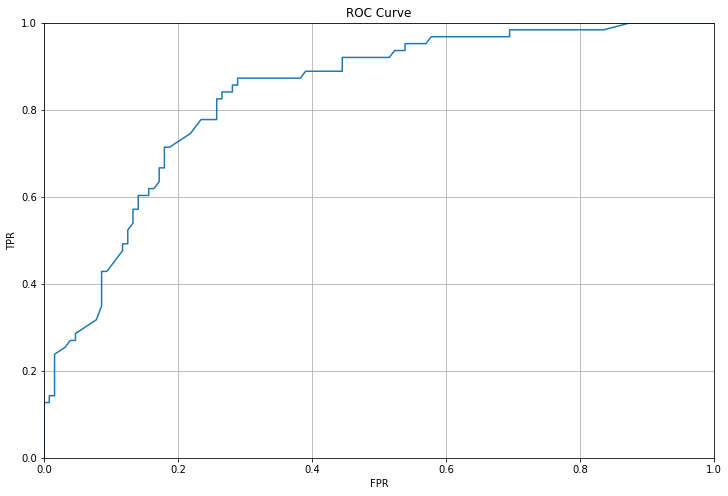

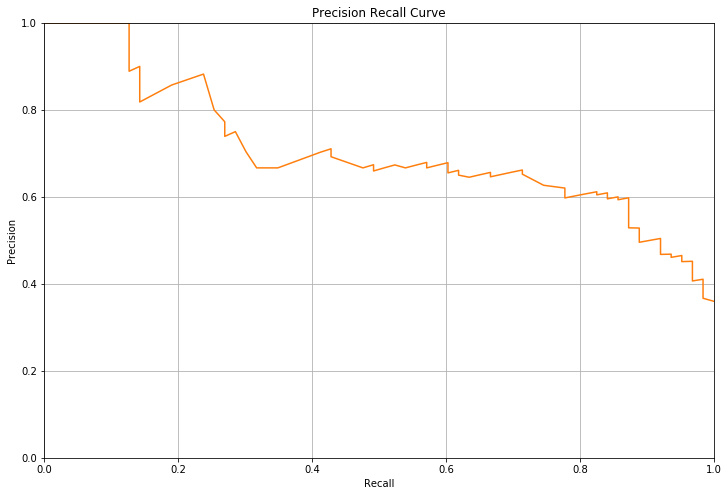

In [21]:
model = rfc_grid.best_estimator_

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
balanced_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
fpr, tpr, _ = roc_curve(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, c='C0')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('ROC Curve')

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision Recall Curve');

#### Results

Run 1
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10}

Accuracy: 0.7644
Balanced Accuracy: 0.7644
F1 Score: 0.6939

Confusion Matrix:
    0	1
0	95	33
1	12	51

### Logistic Regression

In [22]:
log_params = {
    'penalty': ('l1', 'l2'),
    'C': [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000],
}

log_grid = GridSearchCV(
    estimator=log,
    param_grid=log_params,
    scoring='balanced_accuracy',    # or f1
    iid=False,
    n_jobs=3,
    cv=5
)

log_grid.fit(X_train, y_train)

print(log_grid.best_params_)

{'C': 1, 'penalty': 'l1'}


In [25]:
model = log_grid.best_estimator_

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
balanced_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)

Accuracy: 0.7801
Balanced Accuracy: 0.7801
F1 Score: 0.7123

Confusion Matrix:


,0,1
0,97,31
1,11,52


In [26]:
# for use with logistic regression only
coef_sort_idx = np.argsort(-np.abs(model.coef_[0]), kind='mergesort')

print('Feature weighting for logistic regression\n')
for idx in coef_sort_idx:
    coef = model.coef_[0][idx]
    
    if coef < 0:
        print('\t%0.4f' % model.coef_[0][idx], data.columns[idx])
    else:
        print('\t %0.4f' % model.coef_[0][idx], data.columns[idx])

Feature weighting for logistic regression

	 0.8666 do_sat
	-0.7720 do_raw
	 0.5680 algalBloomSheen_one_week
	-0.5627 cos_month
	 0.5307 DAILYAverageStationPressure
	-0.4358 DAILYAverageSeaLevelPressure
	 0.3867 algalBloomSheen_one_day
	 0.2381 par_below
	-0.2040 DAILYMaximumDryBulbTemp
	 0.1571 phycocyanin
	 0.1533 sin_month
	 0.1372 turbidity
	 0.1295 cos_wind_dir
	-0.1230 DAILYPrecip_one_day
	 0.0775 algalBloomSheen_three_day
	 0.0673 sin_wind_dir
	-0.0338 air_temp
	-0.0291 wind_speed
	 0.0233 par
	-0.0160 DAILYPrecip
	-0.0135 DAILYPrecip_one_week
	-0.0066 pco2_ppm
	 0.0000 rel_hum
	 0.0000 chlor
	 0.0000 do_wtemp
	 0.0000 DAILYMinimumDryBulbTemp
	 0.0000 DAILYAverageDryBulbTemp
	 0.0000 DAILYDeptFromNormalAverageTemp
	 0.0000 DAILYAverageDewPointTemp
	 0.0000 DAILYAverageWetBulbTemp
	 0.0000 DAILYPrecip_three_day


#### Results

Run 1
{'C': 1, 'penalty': 'l1'}

Accuracy: 0.7566
Balanced Accuracy: 0.7566
F1 Score: 0.6667

Confusion Matrix:
    0	1
0	97	29
1	17	46

### Multi-layer Perceptron

### Support Vector Classifier